<a href="https://colab.research.google.com/github/YanaKhlusova/ML_course/blob/main/glove_Bunin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Notebook is written by [Rajat Gupta/practical-ml-implementations-in-python](https://www.kaggle.com/datasets/rajat95gupta/practical-ml-implementations-in-python).

Идея: изучить работу GloVe, воспользовавшись указанным кодом, и натренировать свою модель на основе рассказа И. Бунина "Танька". Изначально я хотела вогнать корпус из 22 рассказов писателя 1887-1909 гг., но это считалось слишком долго, так что пример совсем игрушечный: берем из этого корпуса 30 предложений.

С FastText и W2V уже работала в бакалавриате. Если кратко: FastText находит слова, похожие по морфологии (напр., группирует прилагательные по окончаниям -ий, -ай, -ой или инфинитивы глаголов). Это возможно благодаря анализу n-грамм. Полезно для морфологически богатых языков (напр., русского), но по моему опыту не всегда означает семантическое сходство между словами. Word2Vec не имеет этой фишки и работает больше с семантикой.

GloVe анализирует корпуса текстов и смотрит на репрезентации слов по ним в целом (отсюда GLOBAL vectors); FastText и Word2Vec работают с непосредственным контекстом (предложением).

In [1]:
!pip install razdel -q # токенизация по предложениям для рус. яз.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import itertools
import razdel

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt_tab')
nltk.download('stopwords') # checked also SpaCy and snowball, but think they contain too much important for Russian stories words
stopwords = stopwords.words('russian')

bool_train = True

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
# гиперпараметры обучения
# что не поняла, спрашивала у Дипсика

# кол-во эпох обучения
n_epochs = 100

# допустимая погрешность (tolerance)
# используется для ранней остановки обучения:
# если изменение функции потерь становится меньше,
# обучение может быть прекращено досрочно, так как модель уже почти не улучшается. (DeepSeek)
eps = 0.001

n_sents = 30

# размер эмбеддинга (вектора)
embedding_size = 20

# скорость обучения (learning rate)
# Определяет, насколько сильно корректируются веса модели на каждом шаге градиентного спуска.
# Слишком высокое значение может привести к неустойчивости обучения, а слишком низкое – к медленной сходимости. (DeepSeek)
alpha = 0.1

# AdaGrad оптимизатор
# есть в pytorch, но тут используют низкоуровневый пример
# автоматически снижает скорость обучения (DeepSeek)
delta = 0.8

# context_window_size
window_size = 5

# top N similar words
topN = 5

In [4]:
file_path = '/content/bunin.txt'

with open (file_path, 'r', encoding='utf-8') as file:
  text = file.read()

In [5]:
# оригинальный туториал работает с Brown корпусом NLTK
# он состоит из списка токенизированных предложений
# сделаем то же самое для русского текста
sentences = [sentence.text for sentence in razdel.sentenize(text)]

tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

print(tokenized_sentences[:2])

[['ТАНЬКА', 'Таньке', 'стало', 'холодно', ',', 'и', 'она', 'проснулась', '.'], ['Высвободив', 'руку', 'из', 'попонки', ',', 'в', 'которую', 'она', 'неловко', 'закуталась', 'ночью', ',', 'Танька', 'вытянулась', ',', 'глубоко', 'вздохнула', 'и', 'опять', 'сжалась', '.']]


In [45]:
processed_sents = []
for sent in tokenized_sentences[:n_sents]:
    processed_sents.append([word.lower() for word in sent if word.isalnum() and word not in stopwords])

tokens = list(set(list(itertools.chain(*processed_sents))))
n_tokens = len(tokens)
print('Number of Sentences:', n_sents)
print('Number of Tokens:', n_tokens)

Number of Sentences: 30
Number of Tokens: 198


In [21]:
processed_sents[:3]

[['танька', 'таньке', 'стало', 'холодно', 'проснулась'],
 ['высвободив',
  'руку',
  'попонки',
  'которую',
  'неловко',
  'закуталась',
  'ночью',
  'танька',
  'вытянулась',
  'глубоко',
  'вздохнула',
  'сжалась'],
 ['но', 'холодно']]

In [8]:
# ищем совместно встречающиеся слова
def get_co_occurences(token, processed_sents, window_size):
    co_occurences = []
    for sent in processed_sents:
        for idx in (np.array(sent)==token).nonzero()[0]:
            co_occurences.append(sent[max(0, idx-window_size):min(idx+window_size+1, len(sent))])

    co_occurences = list(itertools.chain(*co_occurences))
    co_occurence_idxs = list(map(lambda x: token2int[x], co_occurences))
    co_occurence_dict = Counter(co_occurence_idxs)
    co_occurence_dict = dict(sorted(co_occurence_dict.items()))
    return co_occurence_dict

# строим матрицу из полученных значений (матрицу совместно встречающихся токенов)
def get_co_occurence_matrix(tokens, processed_sents, window_size):
    for token in tokens:
        token_idx = token2int[token]
        co_occurence_dict = get_co_occurences(token, processed_sents, window_size)
        co_occurence_matrix[token_idx, list(co_occurence_dict.keys())] = list(co_occurence_dict.values())

    np.fill_diagonal(co_occurence_matrix, 0)
    return co_occurence_matrix

In [43]:
# честно, не поняла, что тут
def f(X_wc, X_max, alpha):
    if X_wc<X_max:
        return (X_wc/X_max)**alpha
    else:
        return 1

# кастомная функция потерь
def loss_fn(weights, bias, co_occurence_matrix, n_tokens, X_max, alpha):
    total_cost = 0
    for idx_word in range(n_tokens):
        for idx_context in range(n_tokens):
            w_word = weights[idx_word]
            w_context = weights[n_tokens+idx_context]
            b_word = bias[idx_word]
            b_context = bias[n_tokens+idx_context]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            total_cost += f(X_wc, X_max, alpha) * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))**2
    return total_cost

# кастомный градиент
def gradient(weights, bias, co_occurence_matrix, n_tokens, embedding_size, X_max, alpha):
    dw = np.zeros((2*n_tokens, embedding_size))
    db = np.zeros(2*n_tokens)

    # building word vectors
    for idx_word in range(n_tokens):
        w_word = weights[idx_word]
        b_word = bias[idx_word]

        for idx_context in range(n_tokens):
            w_context = weights[n_tokens+idx_context]
            b_context = bias[n_tokens+idx_context]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            value = f(X_wc, X_max, alpha) * 2 * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))
            db[idx_word] += value
            dw[idx_word] += value * w_context

    # building context vectors
    for idx_context in range(n_tokens):
        w_context = weights[n_tokens + idx_context]
        b_context = bias[n_tokens + idx_context]

        for idx_word in range(n_tokens):
            w_word = weights[idx_word]
            b_word = bias[idx_word]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            value = f(X_wc, X_max, alpha) * 2 * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))
            db[n_tokens + idx_context] += value
            dw[n_tokens + idx_context] += value * w_word
    return dw, db

# кастомная функция оптимизатора AdaGrad
def adagrad(weights_init, bias_init, n_epochs, alpha, eps, delta):
    weights = weights_init
    bias = bias_init
    r1 = np.zeros(weights.shape)
    r2 = np.zeros(bias.shape)
    X_max = np.max(co_occurence_matrix)

    norm_grad_weights = []
    norm_grad_bias = []
    costs = []
    n_iter = 0
    cost = 1
    convergence = 1
    while cost>eps:
        dw, db = gradient(weights, bias, co_occurence_matrix, n_tokens, embedding_size, X_max, alpha)

        r1+=(dw)**2
        r2+=(db)**2
        weights -= np.multiply(alpha / (delta + np.sqrt(r1)), dw)
        bias -= np.multiply(alpha / (delta + np.sqrt(r2)), db)

        cost = loss_fn(weights, bias, co_occurence_matrix, n_tokens, X_max, alpha)

        if n_iter%10==0: # !
            print(f'Cost at {n_iter} iterations:', cost.round(3))

        norm_grad_weights.append(np.linalg.norm(dw))
        norm_grad_bias.append(np.linalg.norm(db))
        costs.append(cost)
        n_iter += 1

        if n_iter>=n_epochs:
            convergence = 0
            break

    if convergence:
        print(f'Converged in {len(costs)} epochs..')
    else:
        print(f'Training complete with {n_epochs} epochs..')
    return weights, bias, norm_grad_weights, norm_grad_bias, costs

In [10]:
# отрисовываем результаты обучения
def plotting(costs, last_n_epochs, norm_grad_weights, norm_grad_bias):
    plt.figure(figsize=(20,5))

    plt.subplot(131)
    plt.plot(costs[-last_n_epochs:], c='k')
    plt.title('cost')
    plt.xlabel('epochs')
    plt.ylabel('value')

    plt.subplot(132)
    plt.plot(norm_grad_weights[-last_n_epochs:], c='k')
    plt.title('norm_weights')
    plt.xlabel('epochs')
    plt.ylabel('value')

    plt.subplot(133)
    plt.plot(norm_grad_bias[-last_n_epochs:], c='k')
    plt.title('norm_bias')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.show()

In [11]:
# смотрим на слова
# уменьшаем размерность векторов с помощью PCA
def plotting_word_vectors(weights):
    pca = PCA(n_components = 2)
    weights = pca.fit_transform(weights[:n_tokens])
    explained_var = (100 * sum(pca.explained_variance_)).round(2)
    print(f'Variance explained by 2 components: {explained_var}%')

    fig, ax = plt.subplots(figsize=(20,10))
    for word, x1, x2 in zip(tokens, weights[:,0], weights[:,1]):
        ax.annotate(word, (x1, x2))

    x_pad = 0.5
    y_pad = 1.5
    x_axis_min = np.amin(weights, axis=0)[0] - x_pad
    x_axis_max = np.amax(weights, axis=0)[0] + x_pad
    y_axis_min = np.amin(weights, axis=1)[1] - y_pad
    y_axis_max = np.amax(weights, axis=1)[1] + y_pad

    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

In [46]:
if bool_train:
    token2int = dict(zip(tokens, range(len(tokens))))
    int2token = {v:k for k,v in token2int.items()}

    print('Building co-occurence matrix..')
    co_occurence_matrix = np.zeros(shape=(len(tokens), len(tokens)), dtype='int')
    co_occurence_matrix = get_co_occurence_matrix(tokens, processed_sents, window_size)
    print('Co-occurence matrix shape:', co_occurence_matrix.shape)
    assert co_occurence_matrix.shape == (n_tokens, n_tokens)

    # co-occurence matrix is similar
    assert np.all(co_occurence_matrix.T == co_occurence_matrix)

    print('\nTraining word vectors..')
    weights_init = np.random.random((2 * n_tokens, embedding_size))
    bias_init = np.random.random((2 * n_tokens,))
    weights, bias, norm_grad_weights, norm_grad_bias, costs = adagrad(weights_init, bias_init, n_epochs, alpha, eps, delta)

    # saving weights
    np.save('weights.npy', weights)

Building co-occurence matrix..
Co-occurence matrix shape: (198, 198)

Training word vectors..
Cost at 0 iterations: 15999.714
Cost at 10 iterations: 1076.173
Cost at 20 iterations: 314.934
Cost at 30 iterations: 145.997
Cost at 40 iterations: 86.416
Cost at 50 iterations: 58.667
Cost at 60 iterations: 43.185
Cost at 70 iterations: 33.439
Cost at 80 iterations: 26.775
Cost at 90 iterations: 21.948
Training complete with 100 epochs..


In [23]:
# ищем похожие слова (most_similar в W2V Gensim)
def find_similar_words(csim, token, topN):
    token_idx = token2int[token]
    closest_words = list(map(lambda x: int2token[x], np.argsort(csim[token_idx])[::-1][:topN]))
    return closest_words

# getting cosine similarities between all combinations of word vectors
csim = cosine_similarity(weights[:n_tokens])

# masking diagonal values since they will be most similar
np.fill_diagonal(csim, 0)

In [47]:
token = 'танька'
closest_words = find_similar_words(csim, token, topN)
print(f'Similar words to {token}:', closest_words)

Similar words to танька: ['погодя', 'охапку', 'мать', 'глупо', 'заревел']


In [50]:
token = 'лошадь'
closest_words = find_similar_words(csim, token, topN)
print(f'Similar words to {token}:', closest_words)

Similar words to лошадь: ['сенец', 'окна', 'печи', 'нет', 'проснулась']


In [52]:
token = 'печи'
closest_words = find_similar_words(csim, token, topN)
print(f'Similar words to {token}:', closest_words)

Similar words to печи: ['стала', 'беспременно', 'охапку', 'двор', 'лошадь']


In [53]:
token = 'память'
closest_words = find_similar_words(csim, token, topN)
print(f'Similar words to {token}:', closest_words)

Similar words to память: ['привязал', 'закуталась', 'нету', 'толк', 'избы']


Loading weights..
Plotting learning curves..


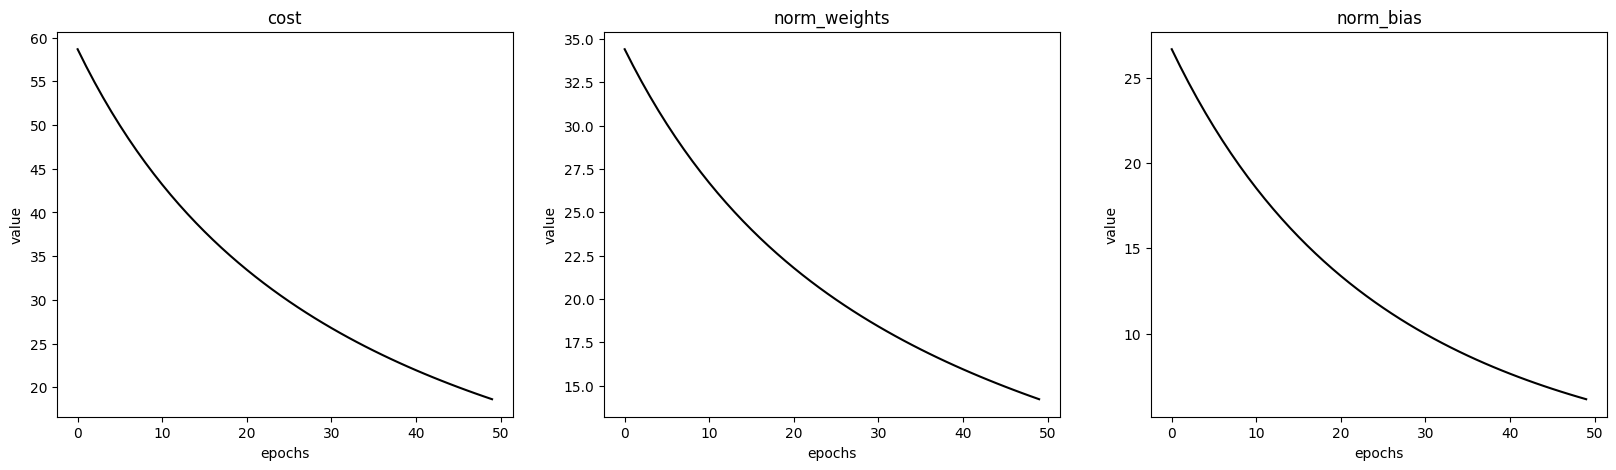

Plotting word vectors..
Variance explained by 2 components: 25.44%


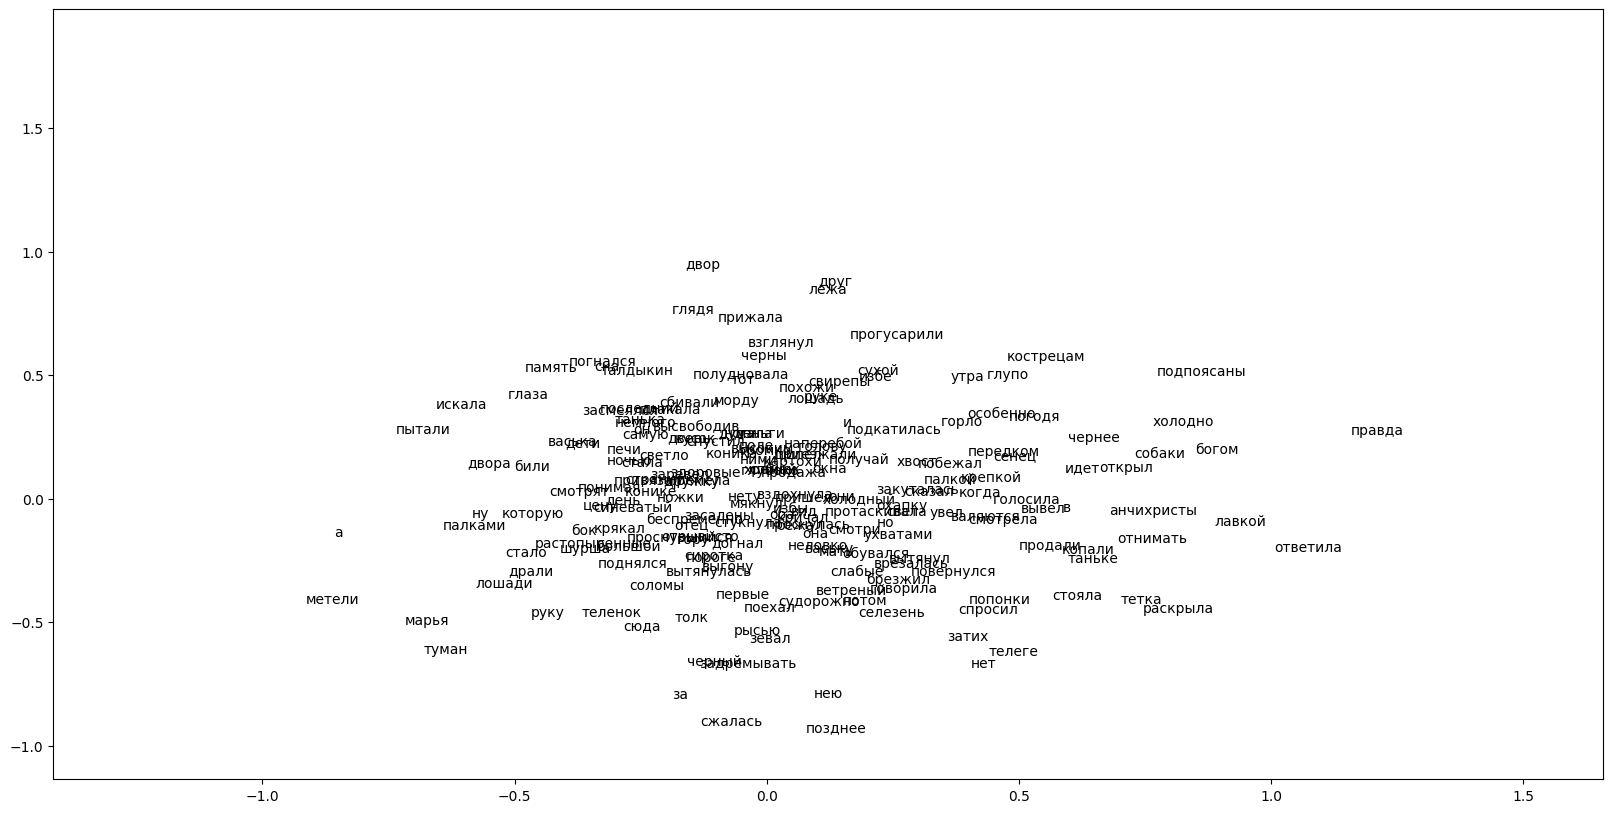

In [54]:
# loading pre-trained weights
print('Loading weights..')
loaded_weights = np.load('weights.npy', allow_pickle=True)

print('Plotting learning curves..')
last_n_epochs = 50 # отрисовываем результаты обучения последних 50 эпох
plotting(costs, last_n_epochs, norm_grad_weights, norm_grad_bias)

print('Plotting word vectors..')
plotting_word_vectors(loaded_weights)

Выводы: как будто бы лучше лемматизировать перед тренировкой модели. Я пыталась искать слова, похожие на "печь", но в корпусе было только "печи". Не могу сказать, что мне понравилось больше: GloVe, W2V или FT, потому что с нуля тренируется действительно тяжело, пример игрушечный, о качестве речи не идет. loss у меня по ощущениям большой получился. Если посмотреть на РСА график, кажется, слова группируются действительно по взаимодействию в корпусе, а не морфологическим/семантическим признакам.

Список стоп-слов пыталась выбрать так, чтобы он захватывал как можно важных для рассказов слов (напр., большой, сначала, человек), поэтому очистка текста оказалась не очень качественной (попали союзы, например). Надо бы сделать потом кастомный словарик...